In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

## config(kernel使うときに変更すべき変数)

In [2]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"


## データ加工部

## CNN(画像＋テーブル)


__version__

__ver1__<br>
train_concat&メタデータ込み：CV:0.974, LB:????<br>
__ver2__<br>
256*256：CV:0.885, LB:0.890<br>
__verSN:1__<br>
metaval:resizeのみ<br>
192_192：OOF: 0.869 Wall time:  1h 33min LB: 0.861<br>
224_224：OOF: 0.883 Wall time:  2h 07min LB: 0.862<br>
256_256：OOF: 0.875 Wall time:  2h 36min LB: 0.882<br>
382_382：OOF: 0.869 Wall time:  5h 10min LB: 0.854<br>
512_512：OOF: 0.848 Wall time: 10h 29min LB: 0.852<br>
__verSN:2__<br>
metaval:metaの組み込み<br>
64_64  ：OOF: 0.856 Wall time: 20min 50s LB: 0.852<br>
256_256：OOF: 0.874 Wall time: 2h 31min 55s LB: 0.885<br>
__verSN:3__<br>
stackingに切り替え<br>
64_64  ：OOF: 0.876 Wall time: 30min 59s    LB: 0.8779<br>
128_128：OOF: 0.881 Wall time: about 50min  LB: 0.8756<br>
192_192：OOF: 0.893 Wall time: 2h 10min 17s LB: 0.8813<br>
224_224：OOF: 0.892 Wall time: 2h 41min 8s  LB: 0.8807<br>
256_256：OOF: 0.897 Wall time: 3h 24min 25s LB: 0.8760<br>
384_384：OOF: 0.872 Wall time: 7h 26min 48s LB: 0.8676<br>
__verSN:4__<br>
tfrecordによるfold + epoch20<br>
64_64  ：OOF: 0.873 Wall time: 38min 15s    LB:0.8856 <br>
96_96  ：OOF: 0.879 Wall time: 54min 34s    LB:0.8719 <br>
128_128：OOF: 0.882 Wall time: 1h 20min 49s LB:0.8929 <br>
160_160：OOF: 0.884 Wall time: 2h 8min 24s  LB:0.8678 <br>
192_192：OOF: 0.885 Wall time: 不明         LB:0.8704 <br>
__verSN:5__<br>
2019データ<br>
64_64  ：OOF: 0.903 Wall time: 30min 37s    LB:0.7135 <br>
128_128：OOF: 0.924 Wall time: 不明         LB:0.7449 <br>
__verSN:6__<br>
train + malignant2019 merge<br>
64_64  ：OOF: 0.821 Wall time: 24min 19s    LB:0.8924 <br>
128_128：OOF: 0.891 Wall time: 1h 12min 48s LB:0.8891 <br>
256_256：OOF: 0.900 Wall time: 4h 19min 32s LB:0.8857 <br>
__verSN:7__<br>
train + malignant2019 merge → BGR2GRAY<br>
64_64  ：OOF: 0.812 Wall time: 27min        LB:0.8396 <br>
128_128：OOF: 0.889 Wall time: 1h 5min 16s  LB:0.8633 <br>
256_256：OOF: 0.897 Wall time: 3h 44min 52s LB:0.8523 <br>

In [3]:
# At least fixing some random seeds. 
# It is still impossible to make results 100% reproducible when using GPU
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, 
                 transforms = None,  meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description→学習に使わない
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(im_path)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            #X_data_np = np.array(x)
            #print("transfor前")
            #print(X_data_np.shape)
            #y_data_np = np.array(y)
            x = self.transforms(x)
            
        if self.train:
            y = self.df.loc[index]['target']
            #return (x, meta), y
            #print(y)
            #X_data_np = np.array(x)
            #print("transform後")
            #print(X_data_np.shape)
            #y_data_np = np.array(y)
            #print(y_data_np.shape)
            return (x, meta), y
        else:
            return (x, meta)
            #return x
    
    def __len__(self):
        return len(self.df)
    
    
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 50 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [6]:
train_transform = transforms.Compose([
    #transforms.RandomResizedCrop(size=224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    #transforms.RandomResizedCrop(size=224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [7]:
arch = EfficientNet.from_pretrained('efficientnet-b1')  # Going to use efficientnet-b0 NN architecture
# skf = StratifiedKFold(n_splits=3, random_state=999, shuffle=True)
skf = GroupKFold(n_splits=5)

Loaded pretrained weights for efficientnet-b1


In [8]:
def TableDataPreprocess2020(dt):
    # One-hot encoding of anatom_site_general_challenge feature
    concat = pd.concat([dt[0]['anatom_site_general_challenge'], dt[1]['anatom_site_general_challenge']], ignore_index=True)
    dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
    dt[0] = pd.concat([dt[0], dummies.iloc[:dt[0].shape[0]]], axis=1)
    dt[1] = pd.concat([dt[1], dummies.iloc[dt[0].shape[0]:].reset_index(drop=True)], axis=1)
    for df in dt:
        df['sex'] = df['sex'].map({'male': 1, 'female': 0})
        df['sex'] = df['sex'].fillna(-1)
        df['age_approx'] /= df['age_approx'].max()
        df['age_approx'] = df['age_approx'].fillna(0)
        df['patient_id'] = df['patient_id'].fillna(0)
    return dt

def TableDataPreprocess2019(dt):
    # One-hot encoding of anatom_site_general_challenge feature
    concat = pd.concat([dt[0]['anatom_site_general_challenge'], dt[1]['anatom_site_general_challenge']], ignore_index=True)
    dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
    dt[0] = pd.concat([dt[0], dummies.iloc[:dt[0].shape[0]]], axis=1)
    dt[1] = pd.concat([dt[1], dummies.iloc[dt[0].shape[0]:].reset_index(drop=True)], axis=1)
    for df in dt:
        df['sex'] = df['sex'].map({'male': 1, 'female': 0})
        df['sex'] = df['sex'].fillna(-1)
        df['age_approx'] /= df['age_approx'].max()
        df['age_approx'] = df['age_approx'].fillna(0)
    return dt

In [14]:
def Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, model_name, tfrecord = None):
    
    meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
    meta_features.remove('anatom_site_general_challenge')
    
    #sample_sub_metaval_stacking.csv用Imagename
    ImgNm = train_df[['image_name']]
    
    #nm = model_name.split('_')
    test = MelanomaDataset(df=test_df,
                           imfolder = SIIM_ISIC_Melanoma_Classification + test_folder, 
                           train=False,
                           transforms=test_transform,
                           meta_features=meta_features)
    oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
    
    # We stratify by target value, thus, according to sklearn StratifiedKFold documentation
    # We can fill `X` with zeroes of corresponding length to use it as a placeholder
    # since we only need `y` to stratify the data
    # for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target']), 1):
    for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=tfrecord['tfrecord'].tolist()), 1):
        print('=' * 20, 'Fold', fold, '=' * 20)
        
        best_val = None  # Best validation score within this fold
        patience = es_patience  # Current patience counter
        arch = EfficientNet.from_pretrained('efficientnet-b1')
        model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
        model = model.to(device)
        
        
        optim = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
        criterion = nn.BCEWithLogitsLoss()
        
        train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True),  
                                imfolder = SIIM_ISIC_Melanoma_Classification + train_folder, 
                                train=True, 
                                transforms=train_transform,
                                meta_features=meta_features)
        val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True),
                              imfolder = SIIM_ISIC_Melanoma_Classification + train_folder,
                              train=True,
                              transforms=test_transform,
                              meta_features=meta_features)
    
        train_loader = DataLoader(dataset=train, batch_size=bat_size[0], shuffle=True, num_workers=2)
        val_loader = DataLoader(dataset=val, batch_size=bat_size[1], shuffle=False, num_workers=2)
        test_loader = DataLoader(dataset=test, batch_size=bat_size[2], shuffle=False, num_workers=2)
        
        del train, val
        gc.collect()
        
        for epoch in range(epochs):
            start_time = time.time()
            correct = 0
            epoch_loss = 0
            model.train()
            
            for x, y in train_loader:
                x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
                x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
                y = torch.tensor(y, device=device, dtype=torch.float32)
                
                
                optim.zero_grad()
                z = model(x)
                loss = criterion(z, y.unsqueeze(1))
                loss.backward()
                optim.step()
                pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
                correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
                epoch_loss += loss.item()
    
                
            train_acc = correct / len(train_idx)
    
            model.eval()  # switch model to the evaluation mode
            val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
            with torch.no_grad():  # Do not calculate gradient since we are only predicting
                # Predicting on validation set
                for j, (x_val, y_val) in enumerate(val_loader):
                    x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                    x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                    y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                    z_val = model(x_val)
                    val_pred = torch.sigmoid(z_val)
                    val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
                val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
                val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
                
                print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
                epoch + 1, 
                epoch_loss, 
                train_acc, 
                val_acc, 
                val_roc, 
                str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
                
                scheduler.step(val_roc)
                # During the first iteration (first epoch) best validation is set to None
                if not best_val:
                    best_val = val_roc  # So any validation roc_auc we have is the best one for now
                    torch.save(model, model_path)  # Saving the model
                    continue
                    
                if val_roc >= best_val:
                    best_val = val_roc
                    patience = es_patience  # Resetting patience since we have new best validation accuracy
                    torch.save(model, model_path)  # Saving current best model
                else:
                    patience -= 1
                    if patience == 0:
                        print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                        break
        
        del train_loader, x, y
        gc.collect()
        
        model = torch.load(model_path)  # Loading best model of this fold
        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        test_preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test set
        with torch.no_grad():
            # Predicting on validation set once again to obtain data for OOF
            for _ in range(TTA):
                for j, (x_val, y_val) in enumerate(val_loader):
                    x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                    x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                    y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                    z_val = model(x_val)
                    val_pred = torch.sigmoid(z_val)
                    val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
            val_preds /= TTA
            oof[val_idx] = val_preds.cpu()
            del val_loader, x_val, y_val
            gc.collect()
            
            # Predicting on test set
            for _ in range(TTA):
                for i, x_test in enumerate(test_loader):
                    x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                    x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                    z_test = model(x_test)
                    z_test = torch.sigmoid(z_test)
                    test_preds[i*x_test[0].shape[0]:i*x_test[0].shape[0] + x_test[0].shape[0]] += z_test
            test_preds /= TTA
            del test_loader, x_test, z_test
            gc.collect()
        
    test_preds /= skf.n_splits
    
    print('OOF: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))
    
    return test_preds, oof, ImgNm

In [10]:
def initData2020():
    #train(train+2019malig)
    train_malig = pd.read_csv(SIIM_ISIC_Melanoma_Classification + "train_malig_2.csv")
    train_malig = train_malig[train_malig.tfrecord != -1]
    train_malig = train_malig.drop(['diagnosis', 'benign_malignant', 'width', 'height', 'source', 'ext'], axis=1)
    train_malig = train_malig.reset_index(drop=True)
    tfrecord_malig = train_malig.loc[:,['tfrecord']]
    tfrecord_malig = tfrecord_malig-15
    train_malig = train_malig.drop(['tfrecord'], axis=1)
    
    train_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
    train_df = train_df.drop(['diagnosis','benign_malignant'], axis=1)
    train_df = train_df[train_df.tfrecord != -1]
    train_df = train_df.drop(['width','height','patient_code'], axis=1)

    train_df = train_df.reset_index(drop=True)
    tfrecord = train_df.loc[:,['tfrecord']]
    train_df = train_df.drop(['tfrecord'], axis=1)
    
    train_df = pd.concat([train_df, train_malig], axis=0)
    train_df = train_df.reset_index(drop=True)
    tfrecord = pd.concat([tfrecord, tfrecord_malig], axis=0)
    tfrecord = tfrecord.reset_index(drop=True)
    
    #test
    test_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
    
    return train_df, test_df, tfrecord

def initData2019():
    train_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train_2019year.csv')
    train_df = train_df.drop(['diagnosis','benign_malignant'], axis=1)
    train_df = train_df[train_df.tfrecord != -1]
    train_df = train_df.drop(['width','height'], axis=1) 

    train_df = train_df.reset_index(drop=True)
    tfrecord = train_df.loc[:,['tfrecord']]
    train_df = train_df.drop(['tfrecord'], axis=1)
    
    test_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
    
    train_df = train_df.drop(['patient_id'], axis=1)
    test_df = test_df.drop(['patient_id'], axis=1)
    
    return train_df, test_df, tfrecord

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 24.785 | Train acc: 0.967 | Val acc: 0.975 | Val roc_auc: 0.847 | Training time: 0:00:28
Epoch 002: | Loss: 18.531 | Train acc: 0.976 | Val acc: 0.977 | Val roc_auc: 0.901 | Training time: 0:00:28
Epoch 003: | Loss: 17.675 | Train acc: 0.976 | Val acc: 0.976 | Val roc_auc: 0.883 | Training time: 0:00:28
Epoch 004: | Loss: 16.929 | Train acc: 0.978 | Val acc: 0.974 | Val roc_auc: 0.875 | Training time: 0:00:28
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch 005: | Loss: 14.936 | Train acc: 0.980 | Val acc: 0.979 | Val roc_auc: 0.911 | Training time: 0:00:29
Epoch 006: | Loss: 13.744 | Train acc: 0.981 | Val acc: 0.980 | Val roc_auc: 0.910 | Training time: 0:00:27
Epoch 007: | Loss: 13.035 | Train acc: 0.982 | Val acc: 0.978 | Val roc_auc: 0.910 | Training time: 0:00:27
Epoch     7: reducing learning rate of group 0 to 4.0000e-05.
Epoch 008: | Loss: 11.952

100%|██████████| 281k/281k [00:02<00:00, 113kB/s]  


CPU times: user 21min 22s, sys: 3min 42s, total: 25min 5s
Wall time: 27min


Successfully submitted to SIIM-ISIC Melanoma Classification

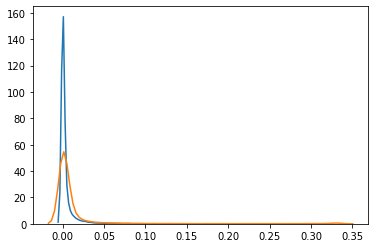

In [16]:
%%time
#64_64_BGR2GRAY
model_name = "64_64_merge_BGR2GRAY"
train_folder = "pad_jpg/train_agm/" + model_name
test_folder = "pad_jpg/test_agm/" + "64_64_BGR2GRAY"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [127, 32, 32] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, model_name, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 44.283 | Train acc: 0.972 | Val acc: 0.976 | Val roc_auc: 0.882 | Training time: 0:01:12
Epoch 002: | Loss: 36.358 | Train acc: 0.976 | Val acc: 0.977 | Val roc_auc: 0.913 | Training time: 0:01:12
Epoch 003: | Loss: 34.270 | Train acc: 0.977 | Val acc: 0.979 | Val roc_auc: 0.915 | Training time: 0:01:12
Epoch 004: | Loss: 32.900 | Train acc: 0.978 | Val acc: 0.981 | Val roc_auc: 0.919 | Training time: 0:01:12
Epoch 005: | Loss: 31.183 | Train acc: 0.980 | Val acc: 0.981 | Val roc_auc: 0.909 | Training time: 0:01:12
Epoch 006: | Loss: 30.359 | Train acc: 0.980 | Val acc: 0.980 | Val roc_auc: 0.931 | Training time: 0:01:12
Epoch 007: | Loss: 29.498 | Train acc: 0.980 | Val acc: 0.978 | Val roc_auc: 0.931 | Training time: 0:01:12
Epoch 008: | Loss: 29.179 | Train acc: 0.981 | Val acc: 0.977 | Val roc_auc: 0.905 | Training time: 0:01:12
Epoch 009: | Loss: 28.623 | Train acc: 0.

100%|██████████| 281k/281k [00:02<00:00, 106kB/s]  


CPU times: user 51min 52s, sys: 13min 7s, total: 1h 4min 59s
Wall time: 1h 5min 16s


Successfully submitted to SIIM-ISIC Melanoma Classification

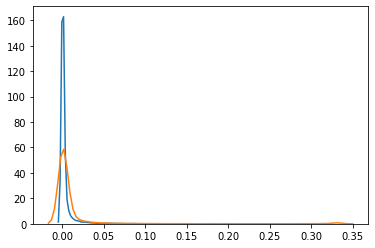

In [17]:
%%time
#128_128_BGR2GRAY
model_name = "128_128_merge_BGR2GRAY"
train_folder = "pad_jpg/train_agm/" + model_name
test_folder = "pad_jpg/test_agm/" + "128_128_BGR2GRAY"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [63, 16, 16] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, model_name, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 84.617 | Train acc: 0.973 | Val acc: 0.980 | Val roc_auc: 0.894 | Training time: 0:03:58
Epoch 002: | Loss: 72.301 | Train acc: 0.977 | Val acc: 0.976 | Val roc_auc: 0.906 | Training time: 0:03:58
Epoch 003: | Loss: 68.727 | Train acc: 0.978 | Val acc: 0.980 | Val roc_auc: 0.903 | Training time: 0:03:58
Epoch 004: | Loss: 66.053 | Train acc: 0.978 | Val acc: 0.980 | Val roc_auc: 0.920 | Training time: 0:03:58
Epoch 005: | Loss: 64.739 | Train acc: 0.979 | Val acc: 0.979 | Val roc_auc: 0.917 | Training time: 0:03:58
Epoch 006: | Loss: 63.113 | Train acc: 0.979 | Val acc: 0.980 | Val roc_auc: 0.893 | Training time: 0:03:58
Epoch     6: reducing learning rate of group 0 to 2.0000e-04.
Epoch 007: | Loss: 52.859 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.935 | Training time: 0:03:58
Epoch 008: | Loss: 48.348 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.939 | Tr

100%|██████████| 277k/277k [00:05<00:00, 50.8kB/s]


CPU times: user 2h 46min 51s, sys: 58min 24s, total: 3h 45min 16s
Wall time: 3h 44min 52s


Successfully submitted to SIIM-ISIC Melanoma Classification

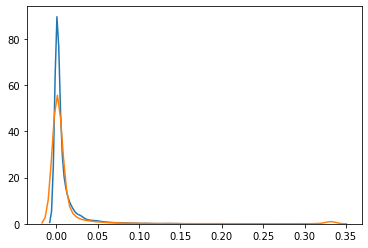

In [18]:
%%time
#256_256_BGR2GRAY
model_name = "256_256_merge_BGR2GRAY"
train_folder = "pad_jpg/train_agm/" + model_name
test_folder = "pad_jpg/test_agm/" + "256_256_BGR2GRAY"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [32, 16, 16] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, model_name, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 24.720 | Train acc: 0.968 | Val acc: 0.975 | Val roc_auc: 0.901 | Training time: 0:00:27
Epoch 002: | Loss: 18.123 | Train acc: 0.976 | Val acc: 0.976 | Val roc_auc: 0.910 | Training time: 0:00:27
Epoch 003: | Loss: 16.782 | Train acc: 0.978 | Val acc: 0.977 | Val roc_auc: 0.918 | Training time: 0:00:27
Epoch 004: | Loss: 16.128 | Train acc: 0.978 | Val acc: 0.979 | Val roc_auc: 0.918 | Training time: 0:00:27
Epoch 005: | Loss: 15.584 | Train acc: 0.978 | Val acc: 0.979 | Val roc_auc: 0.920 | Training time: 0:00:27
Epoch 006: | Loss: 15.175 | Train acc: 0.980 | Val acc: 0.975 | Val roc_auc: 0.903 | Training time: 0:00:27
Epoch 007: | Loss: 15.114 | Train acc: 0.979 | Val acc: 0.980 | Val roc_auc: 0.916 | Training time: 0:00:27
Epoch     7: reducing learning rate of group 0 to 2.0000e-04.
Epoch 008: | Loss: 12.546 | Train acc: 0.982 | Val acc: 0.979 | Val roc_auc: 0.918 | Tr

100%|██████████| 281k/281k [00:03<00:00, 92.0kB/s]


CPU times: user 19min 4s, sys: 3min 19s, total: 22min 23s
Wall time: 24min 19s


Successfully submitted to SIIM-ISIC Melanoma Classification

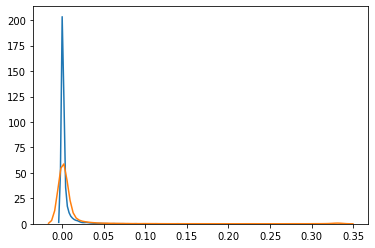

In [11]:
%%time
#64_64
model_name = "64_64_merge"
train_folder = "pad_jpg/train/" + model_name
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [127, 32, 32] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, model_name, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 42.081 | Train acc: 0.974 | Val acc: 0.979 | Val roc_auc: 0.890 | Training time: 0:01:12
Epoch 002: | Loss: 34.809 | Train acc: 0.977 | Val acc: 0.978 | Val roc_auc: 0.898 | Training time: 0:01:12
Epoch 003: | Loss: 32.682 | Train acc: 0.978 | Val acc: 0.979 | Val roc_auc: 0.918 | Training time: 0:01:12
Epoch 004: | Loss: 30.936 | Train acc: 0.980 | Val acc: 0.980 | Val roc_auc: 0.914 | Training time: 0:01:12
Epoch 005: | Loss: 29.994 | Train acc: 0.980 | Val acc: 0.981 | Val roc_auc: 0.918 | Training time: 0:01:12
Epoch     5: reducing learning rate of group 0 to 2.0000e-04.
Epoch 006: | Loss: 24.806 | Train acc: 0.982 | Val acc: 0.980 | Val roc_auc: 0.942 | Training time: 0:01:12
Epoch 007: | Loss: 22.148 | Train acc: 0.984 | Val acc: 0.981 | Val roc_auc: 0.942 | Training time: 0:01:12
Epoch 008: | Loss: 20.681 | Train acc: 0.984 | Val acc: 0.978 | Val roc_auc: 0.943 | Tr

100%|██████████| 281k/281k [00:03<00:00, 91.8kB/s]


CPU times: user 57min 21s, sys: 14min 43s, total: 1h 12min 4s
Wall time: 1h 12min 48s


Successfully submitted to SIIM-ISIC Melanoma Classification

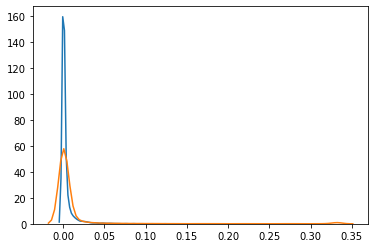

In [12]:
%%time
#128_128_merge
model_name = "128_128_merge"
train_folder = "pad_jpg/train/" + model_name
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [63, 16, 16] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, model_name, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 84.654 | Train acc: 0.973 | Val acc: 0.980 | Val roc_auc: 0.914 | Training time: 0:04:00
Epoch 002: | Loss: 70.674 | Train acc: 0.977 | Val acc: 0.980 | Val roc_auc: 0.918 | Training time: 0:04:00
Epoch 003: | Loss: 66.905 | Train acc: 0.978 | Val acc: 0.981 | Val roc_auc: 0.917 | Training time: 0:04:00
Epoch 004: | Loss: 63.710 | Train acc: 0.979 | Val acc: 0.980 | Val roc_auc: 0.903 | Training time: 0:04:00
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch 005: | Loss: 54.073 | Train acc: 0.981 | Val acc: 0.982 | Val roc_auc: 0.939 | Training time: 0:04:00
Epoch 006: | Loss: 51.511 | Train acc: 0.981 | Val acc: 0.981 | Val roc_auc: 0.940 | Training time: 0:04:00
Epoch 007: | Loss: 48.286 | Train acc: 0.982 | Val acc: 0.980 | Val roc_auc: 0.937 | Training time: 0:04:00
Epoch 008: | Loss: 46.173 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.938 | Tr

100%|██████████| 280k/280k [00:03<00:00, 83.0kB/s] 


CPU times: user 3h 11min 32s, sys: 1h 8min, total: 4h 19min 32s
Wall time: 4h 19min 32s


Successfully submitted to SIIM-ISIC Melanoma Classification

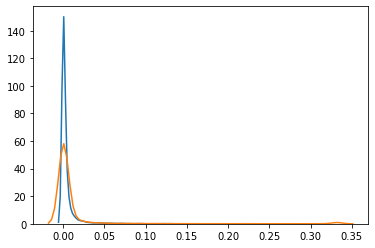

In [13]:
%%time
#256_256_merge
model_name = "256_256_merge"
train_folder = "pad_jpg/train/" + model_name
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [32, 16, 16] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, model_name, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

In [12]:
#192_192
model_name = "192_192_2019year"
train_folder = "pad_jpg/train/" + model_name
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [63, 32, 32] #train, val, test

#データ整形
train_df, test_df, tfrecord %%time
#128_128_merge
model_name = "128_128_merge"
train_folder = "pad_jpg/train/" + model_name
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [63, 32, 32] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, model_name, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)= initData2019()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2019(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, model_name, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 112.353 | Train acc: 0.856 | Val acc: 0.868 | Val roc_auc: 0.862 | Training time: 0:01:46
Epoch 002: | Loss: 96.099 | Train acc: 0.875 | Val acc: 0.875 | Val roc_auc: 0.880 | Training time: 0:01:46
Epoch 003: | Loss: 92.123 | Train acc: 0.881 | Val acc: 0.859 | Val roc_auc: 0.854 | Training time: 0:01:46
Epoch 004: | Loss: 84.223 | Train acc: 0.892 | Val acc: 0.875 | Val roc_auc: 0.895 | Training time: 0:01:46
Epoch 005: | Loss: 78.606 | Train acc: 0.902 | Val acc: 0.849 | Val roc_auc: 0.872 | Training time: 0:01:46
Epoch 006: | Loss: 74.807 | Train acc: 0.905 | Val acc: 0.887 | Val roc_auc: 0.867 | Training time: 0:01:46
Epoch     6: reducing learning rate of group 0 to 2.0000e-04.
Epoch 007: | Loss: 54.501 | Train acc: 0.932 | Val acc: 0.902 | Val roc_auc: 0.925 | Training time: 0:01:46
Epoch 008: | Loss: 45.130 | Train acc: 0.945 | Val acc: 0.899 | Val roc_auc: 0.929 | T

Traceback (most recent call last):
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 70.258 | Train acc: 0.981 | Val acc: 0.983 | Val roc_auc: 0.831 | Training time: 0:03:10
Epoch 002: | Loss: 63.539 | Train acc: 0.982 | Val acc: 0.983 | Val roc_auc: 0.819 | Training time: 0:03:11
Epoch 003: | Loss: 61.871 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.788 | Training time: 0:03:11
Epoch     3: reducing learning rate of group 0 to 2.0000e-04.
Epoch 004: | Loss: 55.271 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.882 | Training time: 0:03:11
Epoch 005: | Loss: 51.689 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.901 | Training time: 0:03:11
Epoch 006: | Loss: 49.692 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.885 | Training time: 0:03:11
Epoch 007: | Loss: 47.340 | Train acc: 0.983 | Val acc: 0.980 | Val roc_auc: 0.884 | Training time: 0:03:11
Epoch     7: reducing learning rate of group 0 to 4.0000e-05.
Epoch 008: | Loss: 40.859

100%|██████████| 280k/280k [00:04<00:00, 59.3kB/s]


CPU times: user 2h 1min 2s, sys: 40min, total: 2h 41min 2s
Wall time: 2h 41min 8s


Successfully submitted to SIIM-ISIC Melanoma Classification

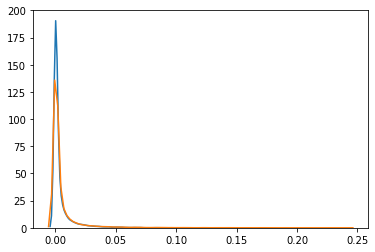

In [19]:
%%time
#224_224
model_name = "224_224"
train_folder = "pad_jpg/train/" + model_name
epochs = 10  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [32, 16, 16] #train, val, test

test_preds, metaval_preds = Exec(epochs, model_path, es_patience, TTA, bat_size)


sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

In [ ]:
%%time
#256_256_2019year
model_name = "256_256_2019year"
train_folder = "pad_jpg/train/" + model_name
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [31, 16, 16] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2019()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2019(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, model_name, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 143.848 | Train acc: 0.982 | Val acc: 0.983 | Val roc_auc: 0.864 | Training time: 0:08:47
Epoch 002: | Loss: 139.551 | Train acc: 0.982 | Val acc: 0.983 | Val roc_auc: 0.724 | Training time: 0:08:47
Epoch 003: | Loss: 131.396 | Train acc: 0.982 | Val acc: 0.983 | Val roc_auc: 0.848 | Training time: 0:08:47
Epoch     3: reducing learning rate of group 0 to 2.0000e-04.
Epoch 004: | Loss: 116.813 | Train acc: 0.982 | Val acc: 0.983 | Val roc_auc: 0.876 | Training time: 0:08:47
Epoch 005: | Loss: 113.272 | Train acc: 0.982 | Val acc: 0.983 | Val roc_auc: 0.880 | Training time: 0:08:48
Epoch 006: | Loss: 110.908 | Train acc: 0.982 | Val acc: 0.983 | Val roc_auc: 0.867 | Training time: 0:08:47
Epoch 007: | Loss: 110.393 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.864 | Training time: 0:08:47
Epoch     7: reducing learning rate of group 0 to 4.0000e-05.
Epoch 008: | Loss:

100%|██████████| 280k/280k [00:06<00:00, 47.4kB/s] 


CPU times: user 5h 25min 7s, sys: 2h 2min 18s, total: 7h 27min 25s
Wall time: 7h 26min 48s


Successfully submitted to SIIM-ISIC Melanoma Classification

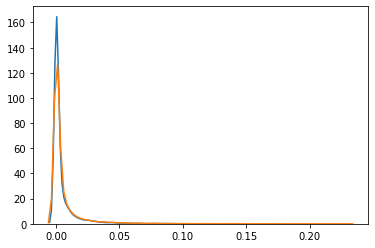

In [24]:
%%time
#384_384
model_name = "384_384"
train_folder = "pad_jpg/train/" + model_name
epochs = 10  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [16, 8, 8] #train, val, test

test_preds, metaval_preds = Exec(epochs, model_path, es_patience, TTA, bat_size)


sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)